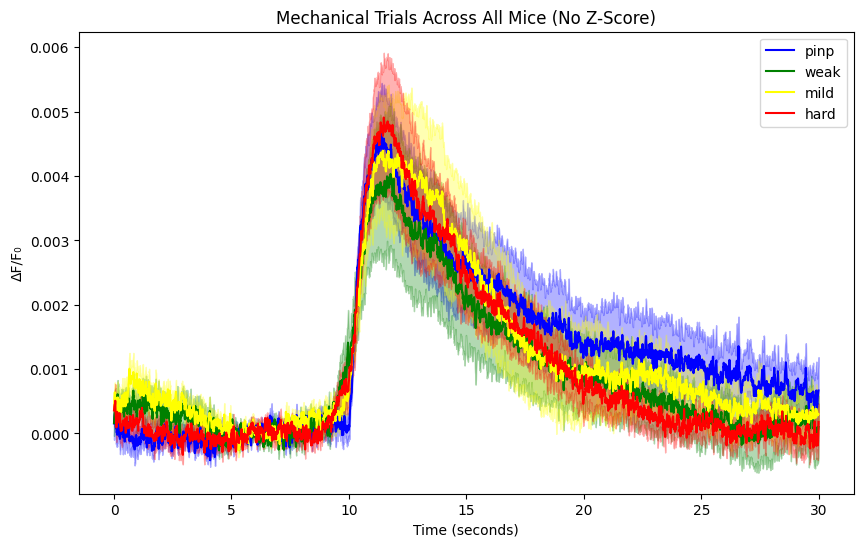

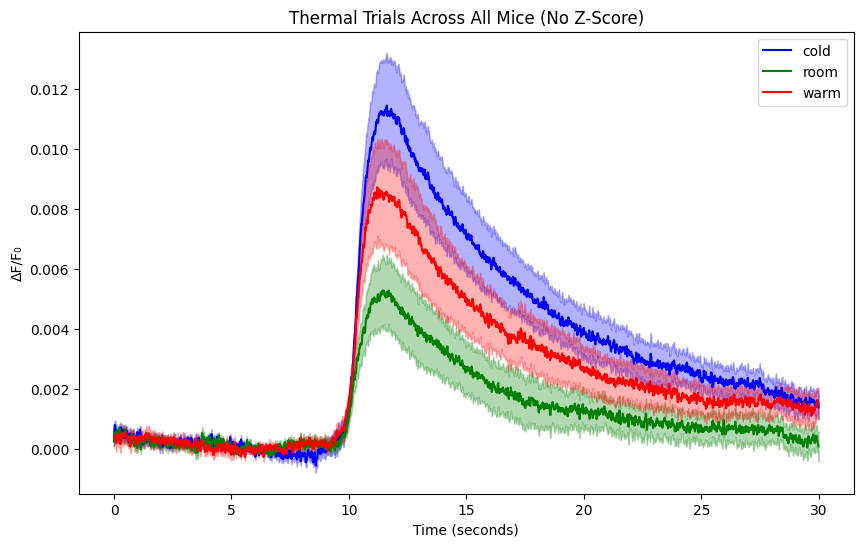

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Path to the uploaded zip file
extract_folder_path = 'E:/sensory_stim/grabda/control/'  # Change this to your desired extraction path

# Loading the data from .npy files
all_data = {animal: np.load(os.path.join(extract_folder_path, animal), allow_pickle=True) 
            for animal in os.listdir(extract_folder_path) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to extract trials for each animal
def extract_trials_per_animal(animal_data, trial_types):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                animal_trials[trial] = data.item()[trial]
        trials[animal] = animal_trials
    return trials

# Extracting trials for each animal
mechanical_data_no_zscore = extract_trials_per_animal(all_data, mechanical_trials)
thermal_data_no_zscore = extract_trials_per_animal(all_data, thermal_trials)

# Function to calculate average and SEM across all animals for each trial type
def calculate_avg_sem_across_animals(data_per_animal, trial_types):
    avg_sem = {}
    for trial in trial_types:
        trial_data = np.array([animal_data[trial] for animal_data in data_per_animal.values() if trial in animal_data])
        avg, sem_val = np.mean(trial_data, axis=0), sem(trial_data, axis=0)
        avg_sem[trial] = (avg, sem_val)
    return avg_sem

# Calculating average and SEM for mechanical and thermal trials
mechanical_avg_sem_no_zscore = calculate_avg_sem_across_animals(mechanical_data_no_zscore, mechanical_trials)
thermal_avg_sem_no_zscore = calculate_avg_sem_across_animals(thermal_data_no_zscore, thermal_trials)

# Defining custom color codes for each trial type
color_codes = {
    'average_trace_cold': 'blue',
    'average_trace_room': 'green',
    'average_trace_warm': 'red',
    'average_trace_pinp': 'blue',
    'average_trace_weak': 'green',
    'average_trace_mild': 'yellow',
    'average_trace_hard': 'red'
}

# Modified plotting function with custom color codes
def plot_trials_with_colors(trial_data, title, sampling_rate, color_codes):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(len(next(iter(trial_data.values()))[0])) / sampling_rate
    for trial, (avg, error) in trial_data.items():
        color = color_codes.get(trial, 'black')  # Default color is black if not specified
        plt.plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        plt.fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('ΔF/F₀')
    plt.legend()
    plt.show()

# Plotting the trials
plot_trials_with_colors(mechanical_avg_sem_no_zscore, "Mechanical Trials Across All Mice (No Z-Score)", 130, color_codes)
plot_trials_with_colors(thermal_avg_sem_no_zscore, "Thermal Trials Across All Mice (No Z-Score)", 130, color_codes)


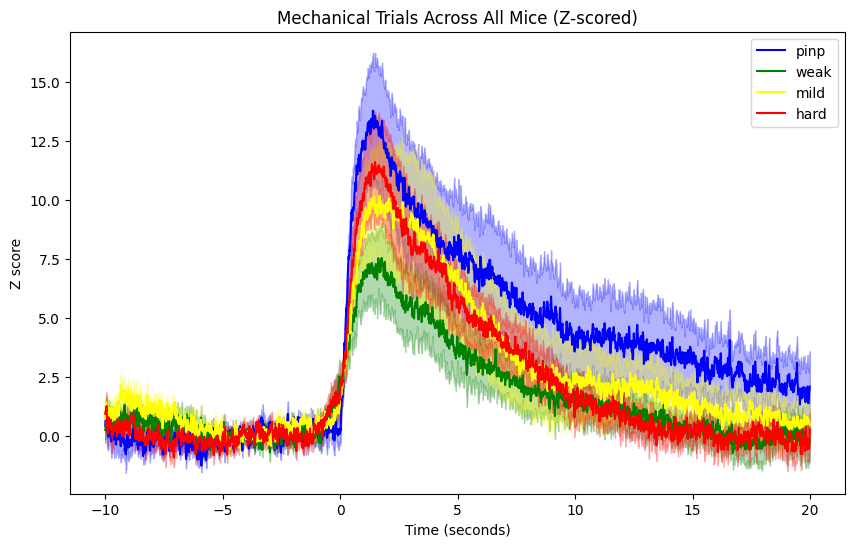

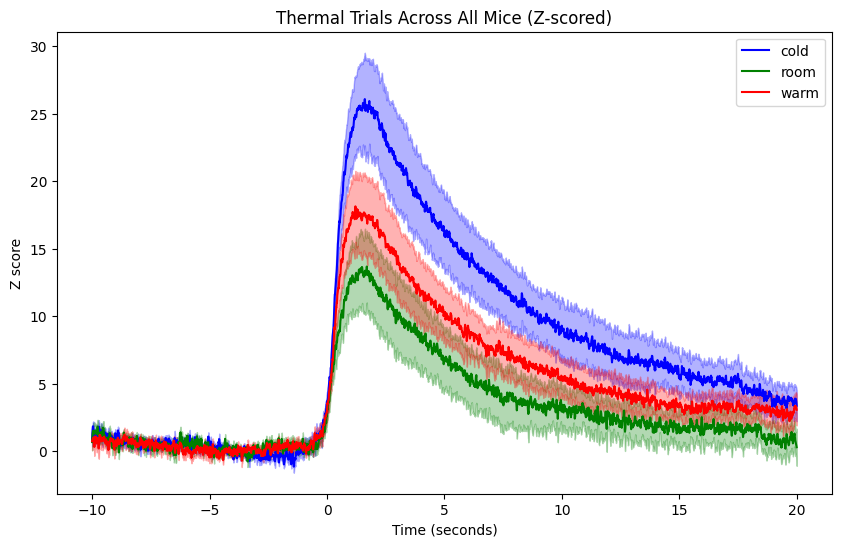

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Path to the uploaded zip file
extract_folder_path = 'E:/sensory_stim/grabda/control/'  # Change this to your desired extraction path

# Loading the data from .npy files
all_data = {animal: np.load(os.path.join(extract_folder_path, animal), allow_pickle=True) 
            for animal in os.listdir(extract_folder_path) if animal.endswith('.npy')}

# Defining trial types
mechanical_trials = ['average_trace_pinp', 'average_trace_weak', 'average_trace_mild', 'average_trace_hard']
thermal_trials = ['average_trace_cold', 'average_trace_room', 'average_trace_warm']

# Function to apply z-score normalization and zero out a specific period
def zscore_and_zero_period(data, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    # Applying z-score normalization with baseline
    baseline_indices = (np.arange(baseline_start, baseline_end, 1/sampling_rate) * sampling_rate).astype(int)
    baseline_mean = np.mean(data[baseline_indices])
    baseline_std = np.std(data[baseline_indices])
    normalized_data = (data - baseline_mean) / baseline_std

    # Zeroing out the specific period
    zero_indices = (np.arange(zero_start, zero_end, 1/sampling_rate) * sampling_rate).astype(int)
    zero_mean = np.mean(normalized_data[zero_indices])
    return normalized_data - zero_mean

# Function to extract, normalize, and zero out trials for each animal
def extract_normalize_zero_trials_per_animal(animal_data, trial_types, baseline_start, baseline_end, zero_start, zero_end, sampling_rate):
    trials = {}
    for animal, data in animal_data.items():
        animal_trials = {}
        for trial in trial_types:
            if isinstance(data.item(), dict) and trial in data.item():
                processed_data = zscore_and_zero_period(data.item()[trial], baseline_start, baseline_end, zero_start, zero_end, sampling_rate)
                animal_trials[trial] = processed_data
        trials[animal] = animal_trials
    return trials

# Extracting, normalizing, and zeroing out trials for each animal
baseline_start_sec = 0  # Starting point of the baseline in seconds
baseline_end_sec = 10   # Ending point of the baseline in seconds
zero_start_sec = 5     # Starting point of zeroing out period in seconds
zero_end_sec = 7       # Ending point of zeroing out period in seconds

mechanical_data_processed = extract_normalize_zero_trials_per_animal(all_data, mechanical_trials, 
                                                                     baseline_start_sec, baseline_end_sec, 
                                                                     zero_start_sec, zero_end_sec, 130)
thermal_data_processed = extract_normalize_zero_trials_per_animal(all_data, thermal_trials, 
                                                                  baseline_start_sec, baseline_end_sec, 
                                                                  zero_start_sec, zero_end_sec, 130)

# Calculating average and SEM for mechanical and thermal trials with processed data
mechanical_avg_sem_processed = calculate_avg_sem_across_animals(mechanical_data_processed, mechanical_trials)
thermal_avg_sem_processed = calculate_avg_sem_across_animals(thermal_data_processed, thermal_trials)

# Modified plotting function with custom color codes
def plot_trials_with_colors_zscore(trial_data, title, sampling_rate, color_codes):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(-10, 20, 1/sampling_rate)
    for trial, (avg, error) in trial_data.items():
        color = color_codes.get(trial, 'black')  # Default color is black if not specified
        plt.plot(time_axis, avg, label=trial.split('_')[-1], color=color)
        plt.fill_between(time_axis, avg - error, avg + error, color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Z score')
    plt.legend()
    plt.show()

# Plotting the trials with processed data
plot_trials_with_colors_zscore(mechanical_avg_sem_processed, "Mechanical Trials Across All Mice (Z-scored)", 130, color_codes)
plot_trials_with_colors_zscore(thermal_avg_sem_processed, "Thermal Trials Across All Mice (Z-scored)", 130, color_codes)

In [6]:
import scipy.stats as stats

# Function to extract 11-13 second window data for each trial type
def extract_window_data(data, start_sec, end_sec, sampling_rate):
    start_idx = int(start_sec * sampling_rate)
    end_idx = int(end_sec * sampling_rate)
    window_data = {trial: [animal_data[trial][start_idx:end_idx] for animal_data in data.values() if trial in animal_data] 
                   for trial in data[next(iter(data.keys()))]}
    return {trial: np.mean(np.concatenate(data_list), axis=0) for trial, data_list in window_data.items()}

# Extracting 11-13 second window data for mechanical and thermal trials
mechanical_window_data = extract_window_data(mechanical_data_processed, 11, 13, 130)
thermal_window_data = extract_window_data(thermal_data_processed, 11, 13, 130)

# Function to perform basic statistical tests
def perform_stat_tests(data):
    stats_results = {}
    for trial1 in data:
        for trial2 in data:
            if trial1 != trial2:
                # Performing T-test
                t_stat, p_val = stats.ttest_ind(data[trial1], data[trial2])
                stats_results[(trial1, trial2)] = p_val
    return stats_results

# Performing statistical tests for mechanical and thermal data
mechanical_stats = perform_stat_tests(mechanical_window_data)
thermal_stats = perform_stat_tests(thermal_window_data)

# Displaying results
mechanical_stats, thermal_stats


C:\Users\huang\AppData\Local\Temp\ipykernel_13708\1186669374.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(data[trial1], data[trial2])
c:\Users\huang\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\huang\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


({('average_trace_pinp', 'average_trace_weak'): nan,
  ('average_trace_pinp', 'average_trace_mild'): nan,
  ('average_trace_pinp', 'average_trace_hard'): nan,
  ('average_trace_weak', 'average_trace_pinp'): nan,
  ('average_trace_weak', 'average_trace_mild'): nan,
  ('average_trace_weak', 'average_trace_hard'): nan,
  ('average_trace_mild', 'average_trace_pinp'): nan,
  ('average_trace_mild', 'average_trace_weak'): nan,
  ('average_trace_mild', 'average_trace_hard'): nan,
  ('average_trace_hard', 'average_trace_pinp'): nan,
  ('average_trace_hard', 'average_trace_weak'): nan,
  ('average_trace_hard', 'average_trace_mild'): nan},
 {('average_trace_cold', 'average_trace_room'): nan,
  ('average_trace_cold', 'average_trace_warm'): nan,
  ('average_trace_room', 'average_trace_cold'): nan,
  ('average_trace_room', 'average_trace_warm'): nan,
  ('average_trace_warm', 'average_trace_cold'): nan,
  ('average_trace_warm', 'average_trace_room'): nan})